In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

def preprocess_image(image):
    # Convert grayscale (1 channel) to RGB (3 channels)
    if tf.shape(image)[-1] == 1:
        image = tf.image.grayscale_to_rgb(image)
    # Resize to input shape
    image = tf.image.resize(image, (224, 224))
    return image

# Data augmentation for training to improve generalization
orientation_train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_image,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

orientation_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_image)

# Training data generator
orientation_train_generator = orientation_train_datagen.flow_from_directory(
    '/content/XRAY-Dataset/Gender01/train',  # Use the path to the extracted directory
    target_size=(224, 224),  # Image resolution
    batch_size=32,
    class_mode='categorical'
)

# Test data generator
orientation_test_generator = orientation_test_datagen.flow_from_directory(
    '/content/XRAY-Dataset/Gender01/test',  # Use the path to the extracted directory
    target_size=(224, 224),  # Image resolution
    batch_size=32,
    class_mode='categorical'
)

# Build a ResNet50 model for classification
# Load ResNet50 pre-trained on ImageNet without the top fully-connected layers
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Fine-tuning: Unfreeze some of the deeper layers for additional training
for layer in base_model.layers[:143]:
    layer.trainable = False
for layer in base_model.layers[143:]:
    layer.trainable = True

# Build the top layers for gender classification
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)  # Pooling layer
x = layers.Dense(224, activation='relu')(x)  # Fully connected layer
x = layers.Dropout(0.5)(x)  # Dropout to prevent overfitting
x = layers.Dense(2, activation='softmax')(x)  # Output layer for 2 classes (male/female)

# Create the final model
model = models.Model(inputs=base_model.input, outputs=x)

# Compile the model with a lower learning rate for fine-tuning
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks for learning rate reduction and early stopping
lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.2, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model with data augmentation and fine-tuning
history = model.fit(orientation_train_generator, epochs=5, validation_data=orientation_test_generator,
                    callbacks=[lr_reduction, early_stopping])

# Evaluate the model on test data
orientation_test_loss, orientation_test_acc = model.evaluate(orientation_test_generator)
print(f"Gender Classification Accuracy: {orientation_test_acc:.2f}")


Found 154 images belonging to 2 classes.
Found 93 images belonging to 2 classes.
Epoch 1/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 86s 14s/step - accuracy: 0.5821 - loss: 0.8021 - val_accuracy: 0.5806 - val_loss: 0.8213 - learning_rate: 1.0000e-04
Epoch 2/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 84s 14s/step - accuracy: 0.6409 - loss: 0.6897 - val_accuracy: 0.5591 - val_loss: 0.7146 - learning_rate: 1.0000e-04
Epoch 3/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 76s 13s/step - accuracy: 0.8195 - loss: 0.4241 - val_accuracy: 0.6774 - val_loss: 0.5464 - learning_rate: 1.0000e-04
Epoch 4/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 82s 13s/step - accuracy: 0.8537 - loss: 0.3373 - val_accuracy: 0.7634 - val_loss: 0.4430 - learning_rate: 1.0000e-04
Epoch 5/5
5/5 ━━━━━━━━━━━━━━━━━━━━ 66s 14s/step - accuracy: 0.9054 - loss: 0.2680 - val_accuracy: 0.8495 - val_loss: 0.3288 - learning_rate: 1.0000e-04


In [ ]:
!apt-get install graphviz
!pip install pydot
!pip install pydot-ng


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model

# Define your model (or load your existing model)
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dense(4, activation='softmax')(x)
model = models.Model(inputs=base_model.input, outputs=x)

# Plot model architecture
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

# Display the image in Colab
from PIL import Image
import IPython.display as display

img = Image.open('model_architecture.png')
display.display(img)


InvocationException: Program terminated with status: -6. stderr follows: failed at node 15685[1]
dot: maze.c:313: chkSgraph: Assertion `np->cells[1]' failed.


In [ ]:
import zipfile
import os

# Define the name of the uploaded file
zip_file_name = 'Gender01.zip'  # Replace with the name of your zip file

# Extract the contents of the zip file
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall('/content/XRAY-Dataset')  # Directory to extract to

Image shape: (128, 128, 1)
Image dtype: <dtype: 'uint8'>


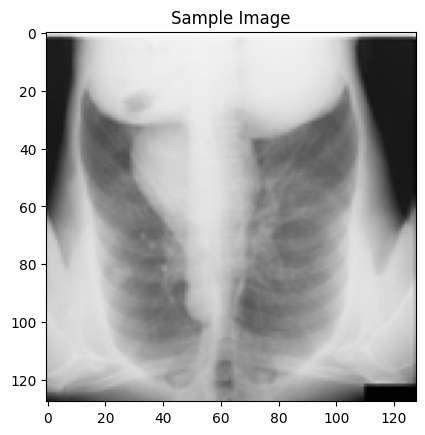

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Load a sample image from the dataset
sample_image_path = '/content/XRAY-Dataset/Directions01/train/down/0.png'

# Load and decode the image
image = tf.io.read_file(sample_image_path)
image = tf.image.decode_jpeg(image, channels=1)  # Set channels=1 for grayscale

# Check the image shape and type
print("Image shape:", image.shape)
print("Image dtype:", image.dtype)

# Display the image
plt.imshow(image.numpy().reshape((128, 128)), cmap='gray')
plt.title("Sample Image")
plt.show()
